In [66]:
import xarray_beam as xb

ds, _ = xb.open_zarr('gcs://gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr')

In [33]:
print(ds.nbytes / (10**9))

41283.60431246


In [67]:
temp = ds['2m_temperature']

In [93]:
import numpy as np
import pandas as pd

lat_min, lat_max = (15, 45.0)
lon_min, lon_max = (115, 145)

lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

source_dataset = ds.isel(latitude=lat_indices, longitude=lon_indices)

start_date = pd.to_datetime('2011-12-28')
end_date = pd.to_datetime('2022-12-29')
source_dataset = source_dataset.sel(time=slice(start_date, end_date))

print(source_dataset)



<xarray.Dataset>
Dimensions:                                           (time: 14628,
                                                       latitude: 121,
                                                       longitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float32 45.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 115...
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_wind_speed                                    (time, latitude, longitude) float32 ...
    2m_temperature                                    (time, latitude, longitude) float32 ...
    angle_of_sub_gridscale_

In [94]:
print(source_dataset.nbytes / (10**9))

92.521750728


In [89]:
dataset = source_dataset.values

(121, 121)


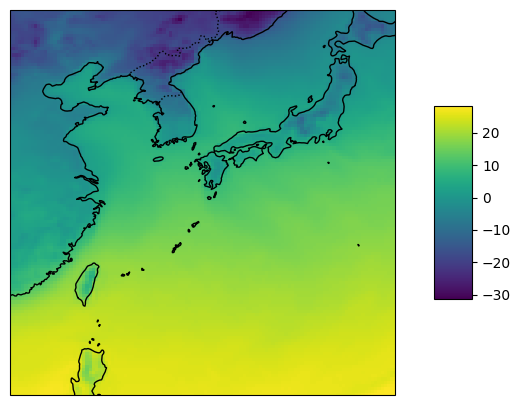

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 예제 NumPy 배열 생성
data = dataset[0][::-1, :]
print(data.shape)

data = data - 273.15

# 지도 생성 및 데이터 시각화
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 지도에 기본 레이어 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# NumPy 배열을 지도 위에 표시 (임의의 위경도 범위에 맞게 조정)
lons = np.linspace(lon_min, lon_max, data.shape[1])
lats = np.linspace(lat_min, lat_max, data.shape[0])
Lons, Lats = np.meshgrid(lons, lats)
mesh = ax.pcolormesh(Lons, Lats, data, transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=5)

plt.show()